In [47]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol
# Import date and time zone libraries
from datetime import datetime
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import pyfolio as pf

Start date,1997-01-02
End date,2018-03-27
Total months,254
,Backtest
Annual return,2.995%
Cumulative returns,86.979%
Annual volatility,19.258%
Sharpe ratio,0.25
Calmar ratio,0.05
Stability,0.02
Max drawdown,-64.204%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,64.20,2007-10-31,2009-03-09,2017-10-20,2603
1,50.71,1999-12-06,2003-03-11,2007-05-18,1945
2,19.54,1998-07-17,1998-08-31,1999-01-06,124
3,12.91,1997-02-13,1997-04-11,1997-05-27,74
4,11.17,1997-08-06,1997-10-27,1998-02-02,129


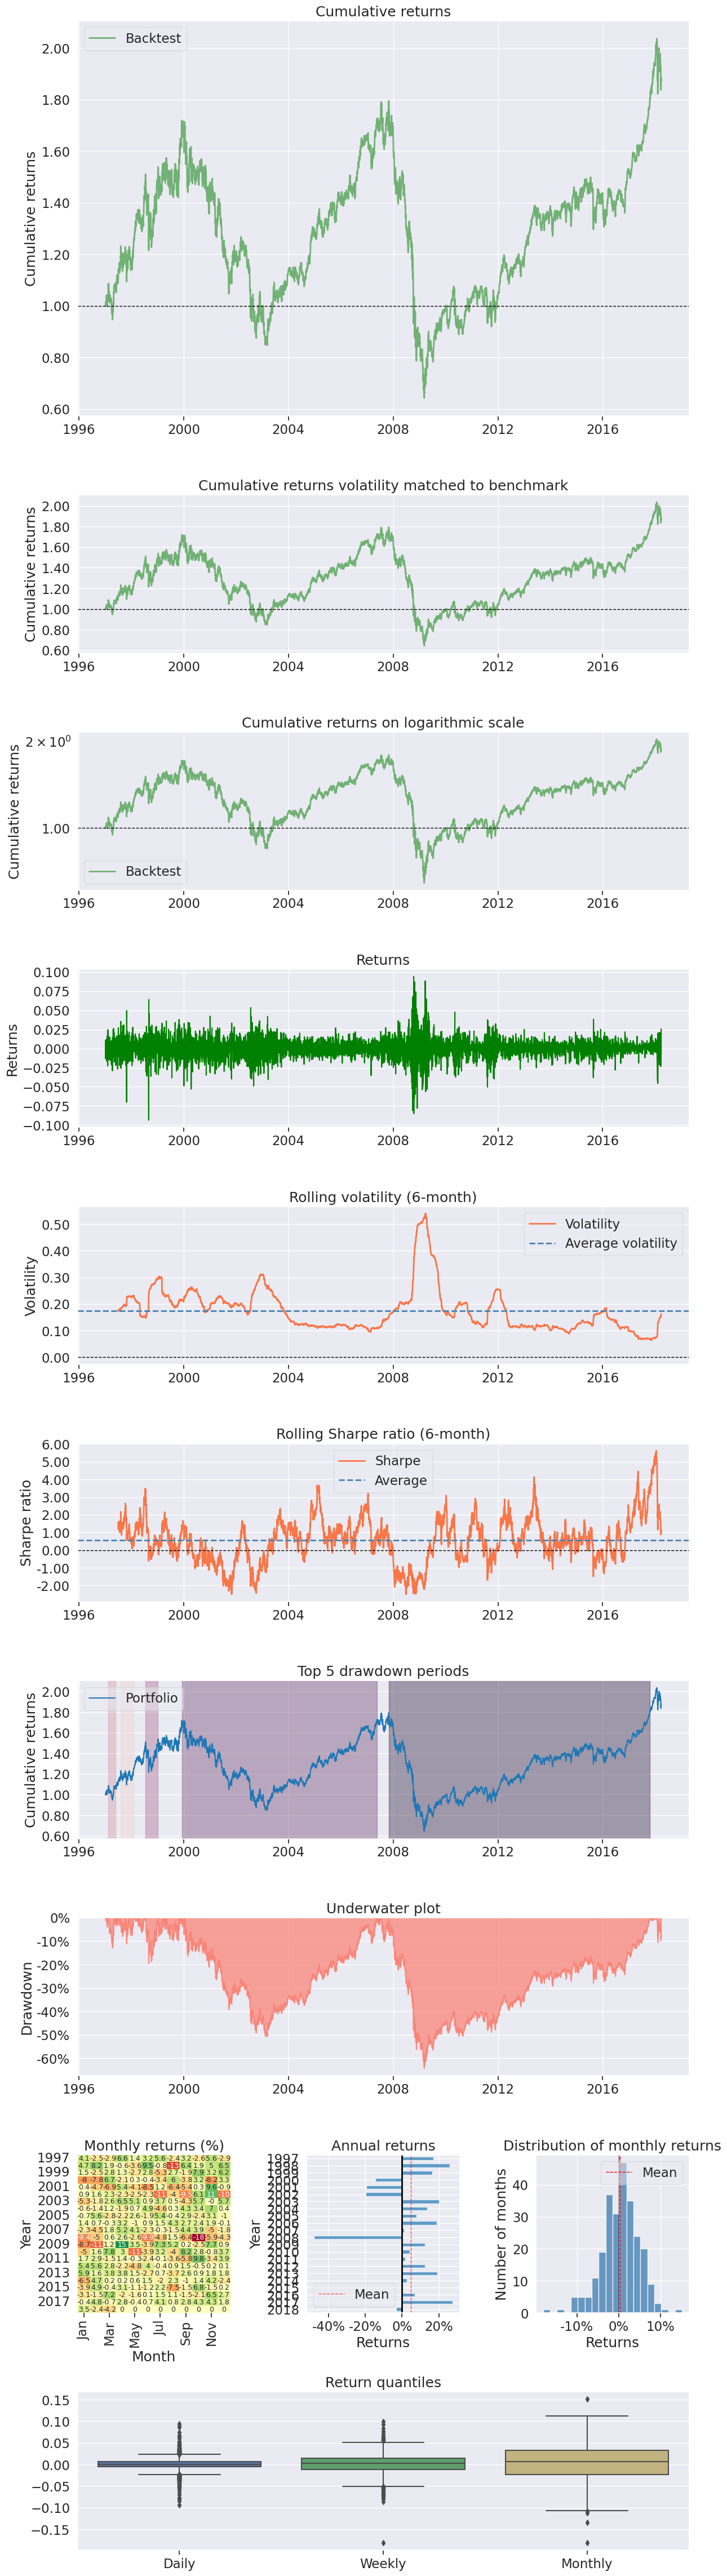

In [48]:
def initialize(context):
    dji = [
            "AAPL",
            "AXP",
            "BA",
            "CAT",
            "CSCO",
            "CVX",
            "DIS",
            "DWDP",
            "GS",
            "HD",
            "IBM",
            "INTC",
            "JNJ",
            "JPM",
            "KO",
            "MCD",
            "MMM",
            "MRK",
            "MSFT",
            "NKE",
            "PFE",
            "PG",
            "TRV",
            "UNH",
            "UTX",
            "V",
            "VZ",
            "WBA",
            "WMT",
            "XOM",  
        ]
    context.dji_symbols = [symbol(s) for s in dji]
    context.check_every_days = 30
def month_perf(ts):
    perf = (ts[-1] / ts[0]) - 1
    return perf
def handle_data(context, data):
    # Get history for all the stocks.
    hist = data.history(context.dji_symbols, "close", 20, "1d")
    
    # This creates a table of percent returns, in order.
    perf_table = hist.apply(month_perf).sort_values(ascending=False)

    # Make buy list of the top N stocks
    buy_list = perf_table[:10]
    
    # The rest will not be held.
    the_rest = perf_table[10:]
    
    # Place target buy orders for top N stocks.
    for stock, perf in buy_list.items():
        stock_weight = 1 / 10

        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # Make sure we are flat the rest.
    for stock, perf in the_rest.items():
        # Place order
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)     

def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_returns_tear_sheet(returns, benchmark_rets=None)

start_date = pd.Timestamp('1997-01-01')
end_date = pd.Timestamp('2018-03-27')
results = run_algorithm(
    start = start_date.tz_localize(None),
    end = end_date.tz_localize(None),
    initialize=initialize,
    analyze=analyze,
    handle_data=handle_data,
    capital_base=10000,
    data_frequency='daily',
    bundle='quandl'
)

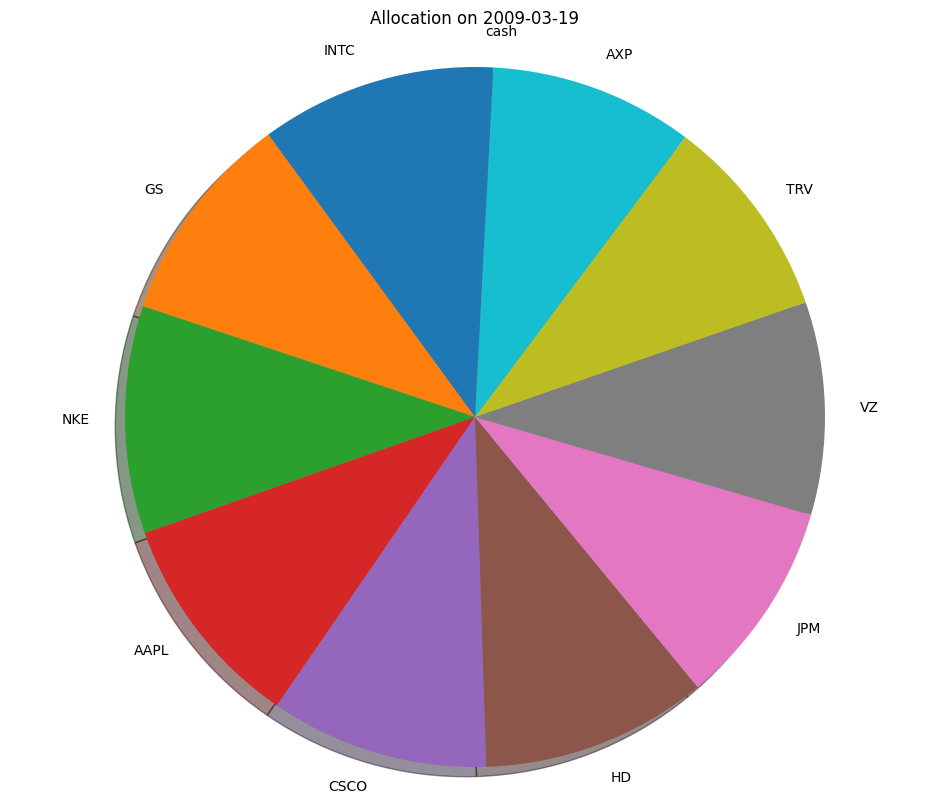

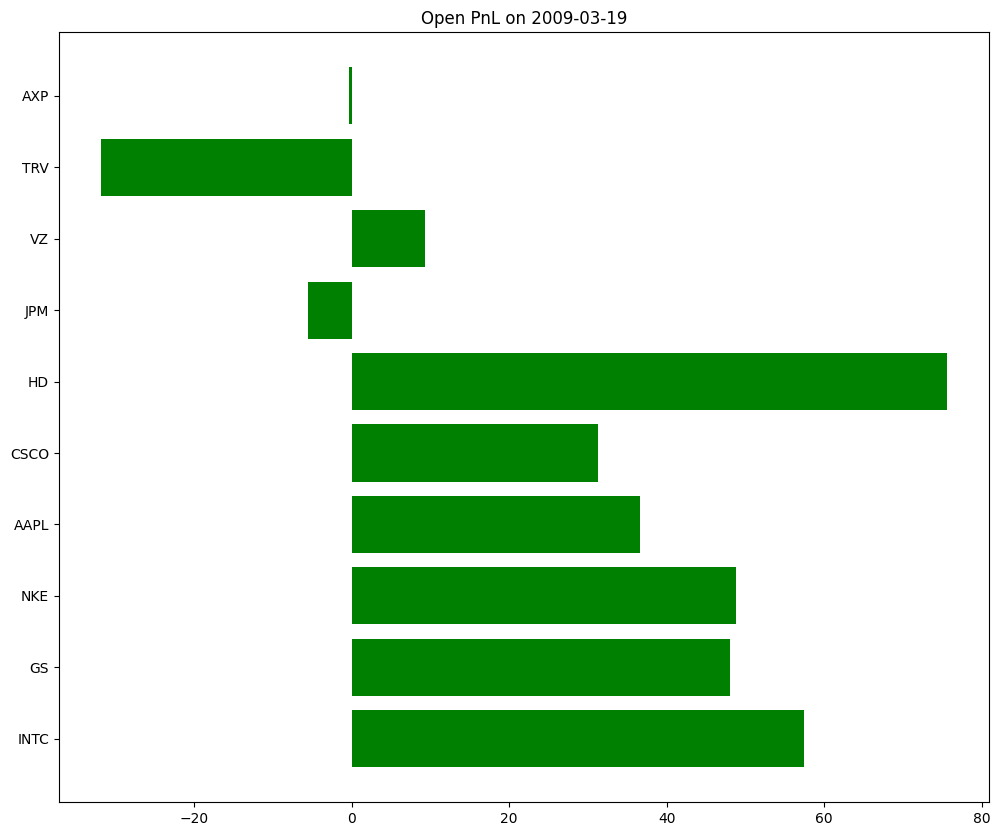

In [49]:


# Select day to view
day = '2009-03-19'

# Get portfolio value and positions for this day
port_value = results.loc[day,'portfolio_value']
day_positions = results.loc[day,'positions']

# Empty DataFrame to store values
df = pd.DataFrame(columns=['value', 'pnl'])


# Populate DataFrame with position info
for pos in day_positions:
    ticker = pos['sid'].symbol 
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
#print(df)
#print(df['value'].isnull().any())
#print(df['value'].sum() > port_value)
#print(port_value, "<", df['value'].sum())

# Add cash position
df.loc['cash', ['value','pnl']] = [(port_value - df['value'].sum()), 0]    

# Make pie chart for allocations
fig, ax1 = plt.subplots(figsize=[12, 10])
ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# Make bar chart for open PnL
fig, ax1 = plt.subplots(figsize=[12, 10])
pnl_df = df.drop('cash')
ax1.barh( pnl_df.index, pnl_df['pnl'],  align='center', color='green', ecolor='black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()